# Data Differences

**Goal**: Are there major differences between data samples from different sources ? Do I need data normalization? Is it the reason why the network performs poorly on the webserver?

**Conclusion:** No, after the spectrogram, its all the same.

## Prerequisites

In [4]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import keras
from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import kapre

Using TensorFlow backend.


In [5]:
# returns path of n'th file below path
def get_path(path, n):
    files = os.listdir(path)
    for i in range(len(files)):
        files[i] = os.path.join(path, files[i])
    return files[n]

# Load a sample with librosa
def get_sample(path):
    sample, sr = librosa.load(path, sr=16000, duration=5.0)
    return sample

# Normalize a sample to have mean=0 and std=1
def get_normalized(data):
    # normalize to have mean=0
    data -= data.mean(axis=0)
    # normalize to have std=1
    return data / data.std(axis=0)

# compute the spectrogramm of a file
def get_spec(data):
    # Run the data through a model consisting only of Spectrogram
    # Empty input of model
    inp = Input(shape=(1, 80000))
    
    # Spectrogram layer
    layer = kapre.time_frequency.Spectrogram(n_dft=512, n_hop=None, padding='same',
                                     power_spectrogram=1.0, return_decibel_spectrogram=True,
                                     trainable_kernel=False, image_data_format='default')(inp)
    # Create Model
    model = Model(inputs=inp, outputs=layer)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy')
    
    # Run model on data
    spec = model.predict(data[None, None, :])
    
    # remove empty dimensions (e.g. batch)
    return np.squeeze(spec)

# Predict the language of a sample with a presaved model
def get_predict(data):
    # Load Model
    path = '../../models/berlin_net.h5'
    model = load_model(path, custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 'Normalization2D': kapre.utils.Normalization2D})
    # Run model on data
    return model.predict(data[None, None, :])

In [6]:
# Draw a Boxplot
def analyze(sample):
    'bBox-plot'
    plt.boxplot(sample, vert=False, whis=50.0)

# Listen to a sample
def listen(data):
    return ipd.Audio(data, rate=16000)

## Voxforge

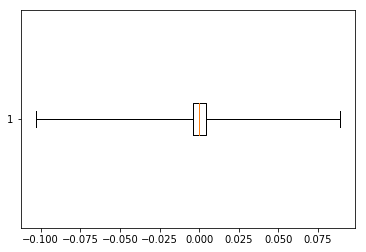

In [7]:
# Load random voxforge file
i = 1
path = get_path('../../data/raw/voxforge/french', i)
sample = get_sample(path)
# Compute normalized version of file
normalized = get_normalized(sample)

# Boxplot of raw file
analyze(sample)

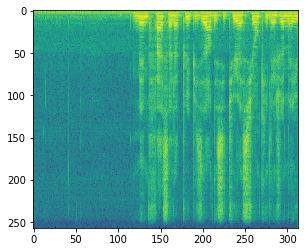

In [8]:
# Show spectrogram of file
plt.imshow(get_spec(sample))

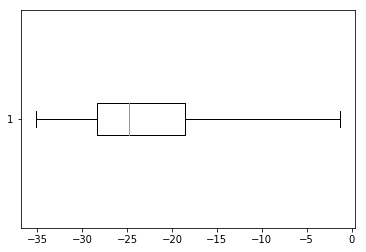

In [9]:
# Show boxplot of spectrogram of file at pos 20
analyze(get_spec(sample)[20])

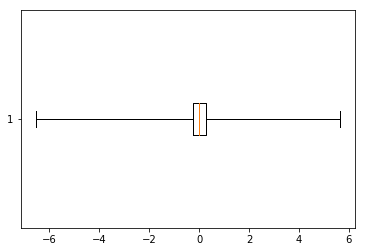

In [11]:
# Boxplot of normalized data
analyze(normalized)

In [12]:
# Listen to the normalized one
listen(normalized)

### Important Keypoints to note for Voxforge
- raw sample is largely in range -0.025 up to + 0.025
- spectrogram is in range -35 up to 0


## Youtube

In [14]:
youtube = get_path('../../data/raw/youtube/fr/bfmtv', 11)

In [15]:
listen(youtube)

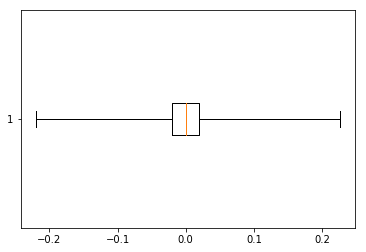

In [20]:
analyze(get_sample(youtube))

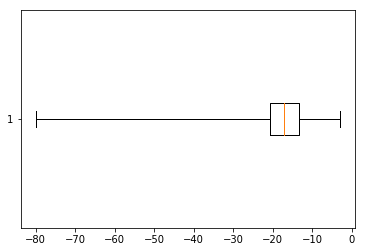

In [21]:
analyze(get_spec(get_sample(youtube))[20])

### Important Keypoints to note for Youtube Sample
- raw sample is largely in range -0.25 up to + 0.25
- spectrogram is in range -80 up to 0

## iPhone - Recording

In [29]:
# Load random sample
i = 1
path = get_path('../../data/raw/guru/de', i)
sample = get_sample(path)

# Create normalized version
normalized = get_normalized(sample)
# Spectogram of raw version
spec = get_spec(sample)
# Spectrogram of normalized version
spec_n = get_spec(normalized)

# Listen to it
listen(sample)

In [24]:
listen(normalized)

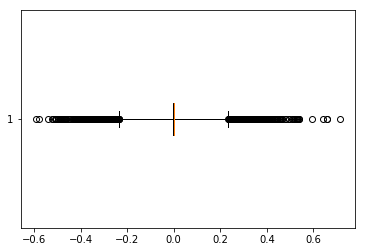

In [26]:
analyze(sample)

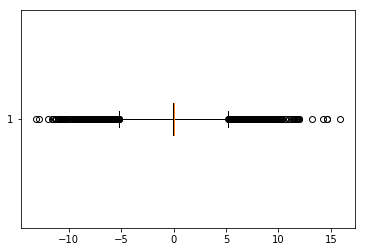

In [25]:
analyze(normalized)

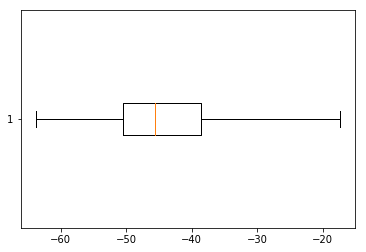

In [27]:
analyze(spec[200])

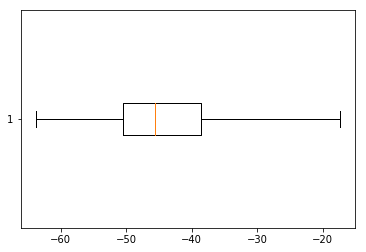

In [28]:
analyze(spec_n[200])

### Iphone Recording keypoints
- raw data is in a range very near to zero
- spectrogram of normalized is same as of non-normalized
- spectrogram is in range -60 up to -20
- normalized and non-normlized sound the same


### Main Conclusion
- data normalization is useless before the spectrogramm, it all turns out the same at the end
- the spectrogramm is always in the same magnitude, e.g -100 up to 0

## Hypothesis: The webserver data is directly recorded as wav while the training data used to be in mp3 format. Does the mp3 loss have an impact on the network? 

In [30]:
# File 0 is random file of guru datasaet
file_0 = get_path('../../data/raw/guru/fr', 1)
# File 2 is the same file but resampled with ffmpeg
file_2 = '../../data/raw/guru/fr/resampled.wav'
# File 1 is the same but as mp3
file_1 = '../../data/raw/guru/fr/asample.mp3'
# File 5 has an ffmpeg butter filter on it
file_5 = '../../data/raw/guru/fr/denoised.wav'

In [31]:
file_0, sr = librosa.load(file_0, sr=16000, duration=5.0)
file_1, sr = librosa.load(file_1, sr=16000, duration=5.0)
file_2, sr = librosa.load(file_2, sr=16000, duration=5.0)
file_5, sr = librosa.load(file_5, sr=16000, duration=5.0)
file_3 = get_normalized(file_0)

FileNotFoundError: [Errno 2] No such file or directory: '/home/joel/Documents/deepLID/data/raw/guru/fr/asample.mp3'

In [81]:
# File 4 is time stretched, e.g. compressed
file_4 = librosa.effects.time_stretch(file_0, 0.7)

In [174]:
ipd.Audio(file_5, rate=16000)
#ipd.Audio(file_1, rate=16000) # clear difference

In [57]:
np.round(get_predict(file_0), decimals=3)

int_axis=1 passed but is ignored, str_axis is used instead.


array([[0.113, 0.861, 0.026]], dtype=float32)

In [58]:
np.round(get_predict(file_1), decimals=3)

int_axis=1 passed but is ignored, str_axis is used instead.


array([[0.029, 0.963, 0.008]], dtype=float32)

In [68]:
np.round(get_predict(file_2), decimals=3)

int_axis=1 passed but is ignored, str_axis is used instead.


array([[0.112, 0.862, 0.026]], dtype=float32)

In [72]:
np.round(get_predict(file_3), decimals=3)

int_axis=1 passed but is ignored, str_axis is used instead.


array([[0.113, 0.861, 0.026]], dtype=float32)

In [85]:
np.round(get_predict(file_4[:80000]), decimals=3)

int_axis=1 passed but is ignored, str_axis is used instead.


array([[0.069, 0.681, 0.25 ]], dtype=float32)

In [175]:
np.round(get_predict(file_5[:80000]), decimals=3)

int_axis=1 passed but is ignored, str_axis is used instead.


array([[0.064, 0.927, 0.009]], dtype=float32)

## -> NO because none of these different versions of the file get predicted much differently 

## Hypothesis: The background noise obstructs the network. Solution is applying a special "filter"

In [87]:
import scipy.signal as signal
import math

In [161]:
# Filter
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
b, a = signal.butter(1, [0.10, 0.30], 'band')
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, file_0, zi=zi*file_0[0])
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
y = signal.filtfilt(b, a, file_0)

In [166]:
ipd.Audio(z2, rate=16000) # sounds different again

In [169]:
np.round(get_predict(z2), decimals=3) # but still doesn't help

int_axis=1 passed but is ignored, str_axis is used instead.


array([[0.124, 0.855, 0.021]], dtype=float32)